# Projekt: Optymalizacja Diety przy użyciu Algorytmów Genetycznych (MWD)

## 1. Opis Problemu
Celem tego projektu jest rozwiązanie Problemu Diety, klasycznego wyzwania optymalizacyjnego. Dążymy do wybrania dziennego menu z zestawu dostępnych produktów spożywczych, które spełnia określone wymagania żywieniowe (Kalorie, Białko, Węglowodany, Tłuszcze), jednocześnie minimalizując koszty i maksymalizując różnorodność posiłków.

### Metodologia
Wykorzystujemy Algorytm Genetyczny (AG) do eksploracji przestrzeni rozwiązań. Rozwiązanie (chromosom) jest reprezentowane przez wektor liczb całkowitych, gdzie każdy gen odpowiada liczbie porcji (100g) określonego produktu spożywczego.

**Kluczowe Cele:**
* Minimalizacja odchylenia od celów żywieniowych (2000 kcal, 60g Białka itp.).
* Minimalizacja dziennego kosztu (Budżet: < 50 PLN).
* Maksymalizacja różnorodności (Premia za używanie różnych składników).

## 2. Konfiguracja i Importy

In [ ]:
import random
import math
import statistics
import matplotlib.pyplot as plt

# Ustawienie ziarna losowości dla powtarzalności wyników
#random.seed(42)

# Parametry konfiguracyjne
CONFIG = {
    'benchmark_runs': 5,        # Liczba uruchomień na eksperyment do uśrednienia wyników
    
    # Cele żywieniowe
    'target_calories': 2000,    # kcal
    'target_protein': 70,       # g
    'target_carbs': 250,        # g
    'target_fat': 25,           # g
    'max_daily_cost': 50,       # PLN
    
    # Wagi funkcji przystosowania (Priorytety)
    'calorie_weight': 1.0,
    'protein_weight': 2.0,      # Wysoki priorytet dla białka
    'carbs_weight': 0.8,
    'fat_weight': 0.2,
    'cost_weight': 1.5,         # Wysoki priorytet dla kosztu
    'variety_bonus': 5.0,       # Zachęta do zróżnicowanej diety
    
    # Parametry Algorytmu Genetycznego
    'pop_size': 500,
    'generations': 150,
    'mutation_rate': 0.10,
    'tournament_size': 5,
    'elitism_enabled': True,
    'elitism_count': 2,
    
    # Ograniczenia genów (Porcje na produkt)
    'min_portion': 0,
    'max_portion': 5,
}

## 3. Przygotowanie Danych
Definiujemy zestaw polskich produktów spożywczych wraz z ich wartościami odżywczymi na 100g oraz ceną.

In [24]:
# Baza danych żywności 
# Format: (Nazwa, Kcal, Białko, Węglowodany, Tłuszcz, Cena)
foods_data = [
    # Zboża
    ("Chleb razowy", 250, 8.5, 46, 3.5, 0.80),
    ("Płatki owsiane", 379, 13.5, 67, 6.5, 0.60),
    ("Ryż biały", 360, 7, 80, 0.5, 0.50),
    ("Makaron pełnoziarnisty", 348, 13, 68, 2.5, 0.90),
    ("Kasza gryczana", 340, 12, 70, 2.5, 1.00),
    # Mięso i Ryby
    ("Piersi z kurczaka", 110, 23, 0, 1.5, 2.50),
    ("Łosoś", 208, 20, 0, 13, 6.00),
    ("Jajka (2 szt = 100g)", 155, 13, 1, 11, 1.50),
    ("Wołowina mielona", 250, 26, 0, 15, 3.50),
    ("Tuńczyk w puszce", 116, 26, 0, 1, 2.80),
    # Nabiał
    ("Twaróg półtłusty", 135, 18, 3, 5, 1.80),
    ("Jogurt naturalny", 60, 4, 5, 3, 0.90),
    ("Mleko 2%", 50, 3.4, 5, 2, 0.35),
    ("Ser żółty Gouda", 356, 25, 2, 27, 4.00),
    # Warzywa
    ("Brokuły", 34, 3, 7, 0.4, 1.20),
    ("Marchewka", 41, 1, 10, 0.2, 0.40),
    ("Pomidory", 18, 1, 4, 0.2, 0.80),
    ("Szpinak", 23, 3, 4, 0.4, 2.00),
    ("Ziemniaki", 77, 2, 17, 0.1, 0.30),
    ("Papryka czerwona", 31, 1, 6, 0.3, 1.50),
    # Owoce
    ("Banany", 89, 1, 23, 0.3, 0.60),
    ("Jabłka", 52, 0.3, 14, 0.2, 0.50),
    ("Pomarańcze", 47, 1, 12, 0.1, 0.70),
    # Orzechy i Tłuszcze
    ("Orzechy włoskie", 654, 15, 14, 65, 6.00),
    ("Migdały", 579, 21, 22, 50, 7.00),
    ("Oliwa z oliwek", 884, 0, 0, 100, 4.00),
    ("Masło", 717, 0.5, 0.1, 81, 3.50),
]

NUM_FOODS = len(foods_data)

## 4. Funkcja Przystosowania (Fitness)
Funkcja ocenia jakość diety.

* **Im niższy wynik, tym lepiej.**
* Stosowane są kary za odchylenia od celów żywieniowych.
* Przyznawana jest ujemna kara (premia) za różnorodność.

In [25]:
def calculate_nutrition(individual):
    """Oblicza sumę makroskładników i koszt dla danego genomu."""
    totals = {'calories': 0, 'protein': 0, 'carbs': 0, 'fat': 0, 'cost': 0, 'variety': 0}
    for i, portions in enumerate(individual):
        if portions > 0:
            totals['variety'] += 1
            food = foods_data[i]
            totals['calories'] += food[1] * portions
            totals['protein'] += food[2] * portions
            totals['carbs'] += food[3] * portions
            totals['fat'] += food[4] * portions
            totals['cost'] += food[5] * portions
    return totals

def calculate_fitness(individual, config):
    """Zwraca wynik przystosowania (Im niższy, tym lepszy)."""
    nutrition = calculate_nutrition(individual)
    
    # 1. Kary za odchylenia od celów
    cal_p = abs(nutrition['calories'] - config['target_calories']) / 100
    prot_p = abs(nutrition['protein'] - config['target_protein']) / 10
    carb_p = abs(nutrition['carbs'] - config['target_carbs']) / 25
    fat_p = abs(nutrition['fat'] - config['target_fat']) / 10
    
    # 2. Kara za przekroczenie budżetu (Miękkie ograniczenie)
    if nutrition['cost'] > config['max_daily_cost']:
        cost_p = (nutrition['cost'] - config['max_daily_cost']) * 10
    else:
        cost_p = nutrition['cost'] / 10  # Niewielka zachęta do oszczędności
        
    # 3. Premia za różnorodność (Ujemna kara)
    variety_bonus = -nutrition['variety'] * config['variety_bonus'] / NUM_FOODS * 10
    
    fitness = (cal_p * config['calorie_weight'] +
               prot_p * config['protein_weight'] +
               carb_p * config['carbs_weight'] +
               fat_p * config['fat_weight'] +
               cost_p * config['cost_weight'] +
               variety_bonus)
    
    # 4. Twarde kary (Sprawdzenie głodu)
    if nutrition['calories'] < 500: fitness += 1000
    if nutrition['protein'] < 20: fitness += 500
        
    return fitness

## 5. Operatory Genetyczne
Implementujemy wiele strategii Krzyżowania i Mutacji, aby sprawdzić, która kombinacja daje najlepszą zbieżność.

Operatory Krzyżowania (Crossover)

1. Uniform Crossover (Krzyżowanie Jednorodne)

    Zasada: Każdy gen potomka jest losowo wybierany od jednego z dwojga rodziców z równym prawdopodobieństwem (rzut monetą).

    Działanie techniczne: Algorytm iteruje po kolei przez wszystkie indeksy w wektorze chromosomu. Dla każdego indeksu losuje liczbę z przedziału 0-1 i jeśli jest mniejsza niż 0.5, kopiuje wartość od pierwszego rodzica, w przeciwnym razie od drugiego. Powstaje dziecko będące mozaiką genów rodziców bez zachowania ciągłych bloków sekwencji.

2. Blend Crossover (Krzyżowanie Mieszające / BLX-alpha)

    Zasada: Tworzy nową wartość genu poprzez wylosowanie liczby z przedziału rozciągniętego wokół wartości obu rodziców, co pozwala na generowanie nowych cech.

    Działanie techniczne: Dla każdego genu algorytm wyznacza zakres pomiędzy wartością genu rodzica A i rodzica B. Zakres ten jest następnie poszerzany o współczynnik alpha w obu kierunkach (poza wartości min/max rodziców). Ostateczna wartość genu dziecka jest losowana z tego nowego przedziału i zaokrąglana do liczby całkowitej.

3. Single Point Crossover (Krzyżowanie Jednopunktowe)

    Zasada: Potomek dziedziczy spójny początkowy fragment chromosomu od jednego rodzica, a końcowy fragment od drugiego.

    Działanie techniczne: Algorytm losuje jeden punkt przecięcia (indeks) w obrębie długości chromosomu. Wszystkie geny przed tym punktem są kopiowane wprost od pierwszego rodzica. Wszystkie geny od punktu przecięcia do końca są kopiowane od drugiego rodzica, łącząc dwie "połówki" w jedno rozwiązanie.

Operatory Mutacji (Mutation)

1. Random Reset Mutation (Mutacja Losowego Resetowania)

    Zasada: Losowo wybrany gen jest zastępowany zupełnie nową, losową wartością z dozwolonego zakresu.

    Działanie techniczne: Jeśli zajdzie warunek prawdopodobieństwa mutacji, algorytm wybiera losowy indeks w chromosomie. Następnie nadpisuje znajdującą się tam wartość nową liczbą całkowitą wylosowaną z globalnego zakresu (np. od 0 do 5 porcji). Pozwala to na wprowadzenie do populacji zupełnie nowego materiału genetycznego.

2. Creep Mutation (Mutacja Pełzająca)

    Zasada: Wartość wybranego genu jest nieznacznie modyfikowana poprzez dodanie lub odjęcie małej wartości, co pozwala na precyzyjne dostrajanie rozwiązania.

    Działanie techniczne: Po wylosowaniu genu do mutacji, algorytm dodaje do jego obecnej wartości losowo -1 lub +1. Wynik jest następnie przycinany (klampowany), aby mieścił się w dozwolonych granicach (min/max porcji). Działa to jak lokalne przeszukiwanie w najbliższym sąsiedztwie obecnego rozwiązania.

3. Swap Mutation (Mutacja Zamiany)

    Zasada: Dwa losowo wybrane geny wewnątrz tego samego chromosomu zamieniają się swoimi wartościami.

    Działanie techniczne: Algorytm losuje dwie różne pozycje (indeksy) w wektorze rozwiązania. Następnie pobiera wartości przypisane do tych pozycji i zamienia je miejscami (np. zamienia ilość porcji chleba z ilością porcji ryżu). Ten typ mutacji zmienia strukturę diety, ale często zachowuje ogólną liczbę porcji w menu.

In [26]:
# --- Strategie Krzyżowania ---
def uniform_crossover(parent1, parent2):
    """Losowo wybiera geny od jednego z rodziców."""
    return [p1 if random.random() < 0.5 else p2 for p1, p2 in zip(parent1, parent2)]

def blend_crossover(parent1, parent2, alpha=0.5):
    """Tworzy mieszankę wartości rodziców (BLX-alpha)."""
    child = []
    for p1, p2 in zip(parent1, parent2):
        min_v, max_v = min(p1, p2), max(p1, p2)
        r = max_v - min_v
        low = max(0, min_v - alpha * r)
        high = max_v + alpha * r
        child.append(max(0, min(5, round(random.uniform(low, high)))))
    return child

def single_point_crossover(parent1, parent2):
    """Dzieli rodziców w losowym punkcie i zamienia końcówki."""
    point = random.randint(1, len(parent1) - 1)
    return parent1[:point] + parent2[point:]

# --- Strategie Mutacji ---
def random_reset_mutation(individual, config):
    """Resetuje losowy gen do losowej poprawnej wartości."""
    if random.random() < config['mutation_rate']:
        idx = random.randint(0, len(individual) - 1)
        individual[idx] = random.randint(config['min_portion'], config['max_portion'])

def creep_mutation(individual, config):
    """Nieznacznie dostosowuje losowy gen (+/- 1 porcja)."""
    if random.random() < config['mutation_rate']:
        idx = random.randint(0, len(individual) - 1)
        individual[idx] = max(config['min_portion'],
                               min(config['max_portion'], individual[idx] + random.choice([-1, 1])))

def swap_mutation(individual, config):
    """Zamienia wartości dwóch losowych genów."""
    if random.random() < config['mutation_rate']:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]

## 6. Wykonanie Algorytmu (Benchmark)
Ta sekcja uruchamia główną pętlę ewolucyjną. Testujemy każdą kombinację operatorów Krzyżowania i Mutacji. 
Przechowujemy również najlepsze znalezione rozwiązanie dla każdej kombinacji, aby zwizualizować je później.

In [27]:
def run_single_experiment(run_config):
    # Inicjalizacja populacji
    population = [[random.randint(run_config['min_portion'], run_config['max_portion'])
                    for _ in range(NUM_FOODS)] for _ in range(run_config['pop_size'])]
    
    for gen in range(run_config['generations']):
        fitness_scores = [calculate_fitness(ind, run_config) for ind in population]
        
        # Elityzm: Zachowaj najlepsze osobniki
        sorted_pop = sorted(zip(population, fitness_scores), key=lambda x: x[1])
        new_pop = [list(x[0]) for x in sorted_pop[:run_config['elitism_count']]]
        
        # Generowanie nowej populacji
        while len(new_pop) < run_config['pop_size']:
            # Selekcja turniejowa
            p1 = list(min(random.sample(list(enumerate(population)), run_config['tournament_size']),
                      key=lambda x: fitness_scores[x[0]])[1])
            p2 = list(min(random.sample(list(enumerate(population)), run_config['tournament_size']),
                      key=lambda x: fitness_scores[x[0]])[1])
            
            # Krzyżowanie
            if run_config['crossover_method'] == 'blend': child = blend_crossover(p1, p2)
            elif run_config['crossover_method'] == 'single_point': child = single_point_crossover(p1, p2)
            else: child = uniform_crossover(p1, p2)
            
            # Mutacja
            if run_config['mutation_method'] == 'creep': creep_mutation(child, run_config)
            elif run_config['mutation_method'] == 'swap': swap_mutation(child, run_config)
            else: random_reset_mutation(child, run_config)
            
            new_pop.append(child)
        population = new_pop
        
    final_scores = [calculate_fitness(ind, run_config) for ind in population]
    best_idx = final_scores.index(min(final_scores))
    return min(final_scores), population[best_idx]

# --- Uruchomienie zestawu testowego (Benchmark) ---
crossovers = ['uniform', 'blend', 'single_point']
mutations = ['random_reset', 'creep', 'swap']

results_log = []
best_solutions_per_combo = {} # Słownik do przechowywania najlepszej diety do wizualizacji

print(f"Rozpoczynanie Benchmarku ({len(crossovers)*len(mutations)} kombinacji)...")
print(f"{'Metoda':<25} | {'Śr. Fitness':<12} | {'Najlepszy Fitness':<12}")
print("-" * 55)

for cx in crossovers:
    for mut in mutations:
        cfg = CONFIG.copy()
        cfg['crossover_method'] = cx
        cfg['mutation_method'] = mut
        
        scores = []
        local_best_score = float('inf')
        local_best_sol = None
        
        for _ in range(CONFIG['benchmark_runs']):
            score, sol = run_single_experiment(cfg)
            scores.append(score)
            # Śledź najlepszy wynik w tej konkretnej kombinacji do wykresu
            if score < local_best_score:
                local_best_score = score
                local_best_sol = sol
        
        # Zapisz do wizualizacji
        name = f"{cx} + {mut}"
        best_solutions_per_combo[name] = local_best_sol
        
        avg_score = statistics.mean(scores)
        best_run = min(scores)
        
        results_log.append((name, avg_score))
        print(f"{name:<25} | {avg_score:<12.2f} | {best_run:<12.2f}")

Rozpoczynanie Benchmarku (9 kombinacji)...
Metoda                    | Śr. Fitness  | Najlepszy Fitness
-------------------------------------------------------
uniform + random_reset    | -23.03       | -23.55      
uniform + creep           | -23.61       | -23.76      
uniform + swap            | -23.47       | -23.76      
blend + random_reset      | -22.69       | -23.55      
blend + creep             | -22.23       | -23.55      
blend + swap              | -23.54       | -23.55      
single_point + random_reset | -21.61       | -22.21      
single_point + creep      | -20.53       | -22.49      
single_point + swap       | -22.35       | -23.50      


## 7. Analiza Wyników (Generowana Dynamicznie)
Poniższy kod analizuje rzeczywiste dane benchmarku, aby określić najlepszą strategię i dietę.

In [28]:
print("### 7.1 Porównanie Wydajności Algorytmów")
print(f"\n**Wniosek:** Strategia **'{best_strategy}'** osiągnęła najlepszy średni wynik w tym uruchomieniu.")

# ---------------------------------------------------------
# Część 2: Znajdź najlepsze rozwiązanie globalne
# ---------------------------------------------------------
global_best_name = None
global_best_sol = None
global_best_score = float('inf')

# Zidentyfikuj najlepsze rozwiązanie globalne we wszystkich strategiach
for name, sol in best_solutions_per_combo.items():
    fit = calculate_fitness(sol, CONFIG)
    if fit < global_best_score:
        global_best_score = fit
        global_best_sol = sol
        global_best_name = name

stats = calculate_nutrition(global_best_sol)

# ---------------------------------------------------------
# Część 3: Rekomendacja Optymalnej Diety (Sformatowane Wyjście)
# ---------------------------------------------------------
print("\n### 7.2 Rekomendacja Optymalnej Diety")
print(f"Najlepsze znalezione rozwiązanie (przez {global_best_name}) osiągnęło wynik fitness **{global_best_score:.2f}**.")

print("\n**Rozkład Wartości Odżywczych:**")
print(f"* **Kalorie:** {stats['calories']:.0f} kcal ({stats['calories']/CONFIG['target_calories']*100:.0f}% celu)")
print(f"* **Białko:** {stats['protein']:.1f} g    (Cel: {CONFIG['target_protein']}g)")
print(f"* **Węglowodany:** {stats['carbs']:.1f} g    (Cel: {CONFIG['target_carbs']}g)")
print(f"* **Tłuszcze:** {stats['fat']:.1f} g     (Cel: {CONFIG['target_fat']}g)")
print(f"* **Koszt:** {stats['cost']:.2f} PLN  (Cel: < {CONFIG['max_daily_cost']} PLN)")

print("\n**Wybrane Menu:**")
print("Algorytm skonstruował zróżnicowane i ekonomiczne menu:")

# Zdefiniuj kategorie na podstawie kolejności w 'foods_data'
# 0-4: Zboża, 5-13: Mięso/Nabiał, 14-19: Warzywa, 20-22: Owoce, 23-26: Tłuszcze
categories = {
    "Baza": range(0, 5),
    "Białka": range(5, 14),
    "Witaminy": range(14, 20),
    "Owoce": range(20, 23),
    "Tłuszcze": range(23, 27)
}

for cat_name, indices in categories.items():
    items = []
    for i in indices:
        if global_best_sol[i] > 0:
            # Format: Nazwa (Liczba)
            items.append(f"{foods_data[i][0]} ({global_best_sol[i]})")
    
    if items:
        print(f"* **{cat_name}:** {', '.join(items)}.")

### 7.1 Porównanie Wydajności Algorytmów

**Wniosek:** Strategia **'uniform + swap'** osiągnęła najlepszy średni wynik w tym uruchomieniu.

### 7.2 Rekomendacja Optymalnej Diety
Najlepsze znalezione rozwiązanie (przez uniform + creep) osiągnęło wynik fitness **-23.76**.

**Rozkład Wartości Odżywczych:**
* **Kalorie:** 1981 kcal (99% celu)
* **Białko:** 70.5 g    (Cel: 70g)
* **Węglowodany:** 250.0 g    (Cel: 250g)
* **Tłuszcze:** 89.4 g     (Cel: 45g)
* **Koszt:** 18.95 PLN  (Cel: < 50 PLN)

**Wybrane Menu:**
Algorytm skonstruował zróżnicowane i ekonomiczne menu:
* **Baza:** Chleb razowy (1), Makaron pełnoziarnisty (1).
* **Białka:** Jajka (2 szt = 100g) (1), Jogurt naturalny (1), Mleko 2% (1).
* **Witaminy:** Brokuły (1), Marchewka (1), Pomidory (1), Szpinak (1), Ziemniaki (1), Papryka czerwona (1).
* **Owoce:** Banany (1), Jabłka (2), Pomarańcze (1).
* **Tłuszcze:** Orzechy włoskie (1).


## 8. Wizualizacja
Wizualizujemy rozkład makroskładników (udział kaloryczny) dla najlepszej diety znalezionej przez każdą z 9 strategii.

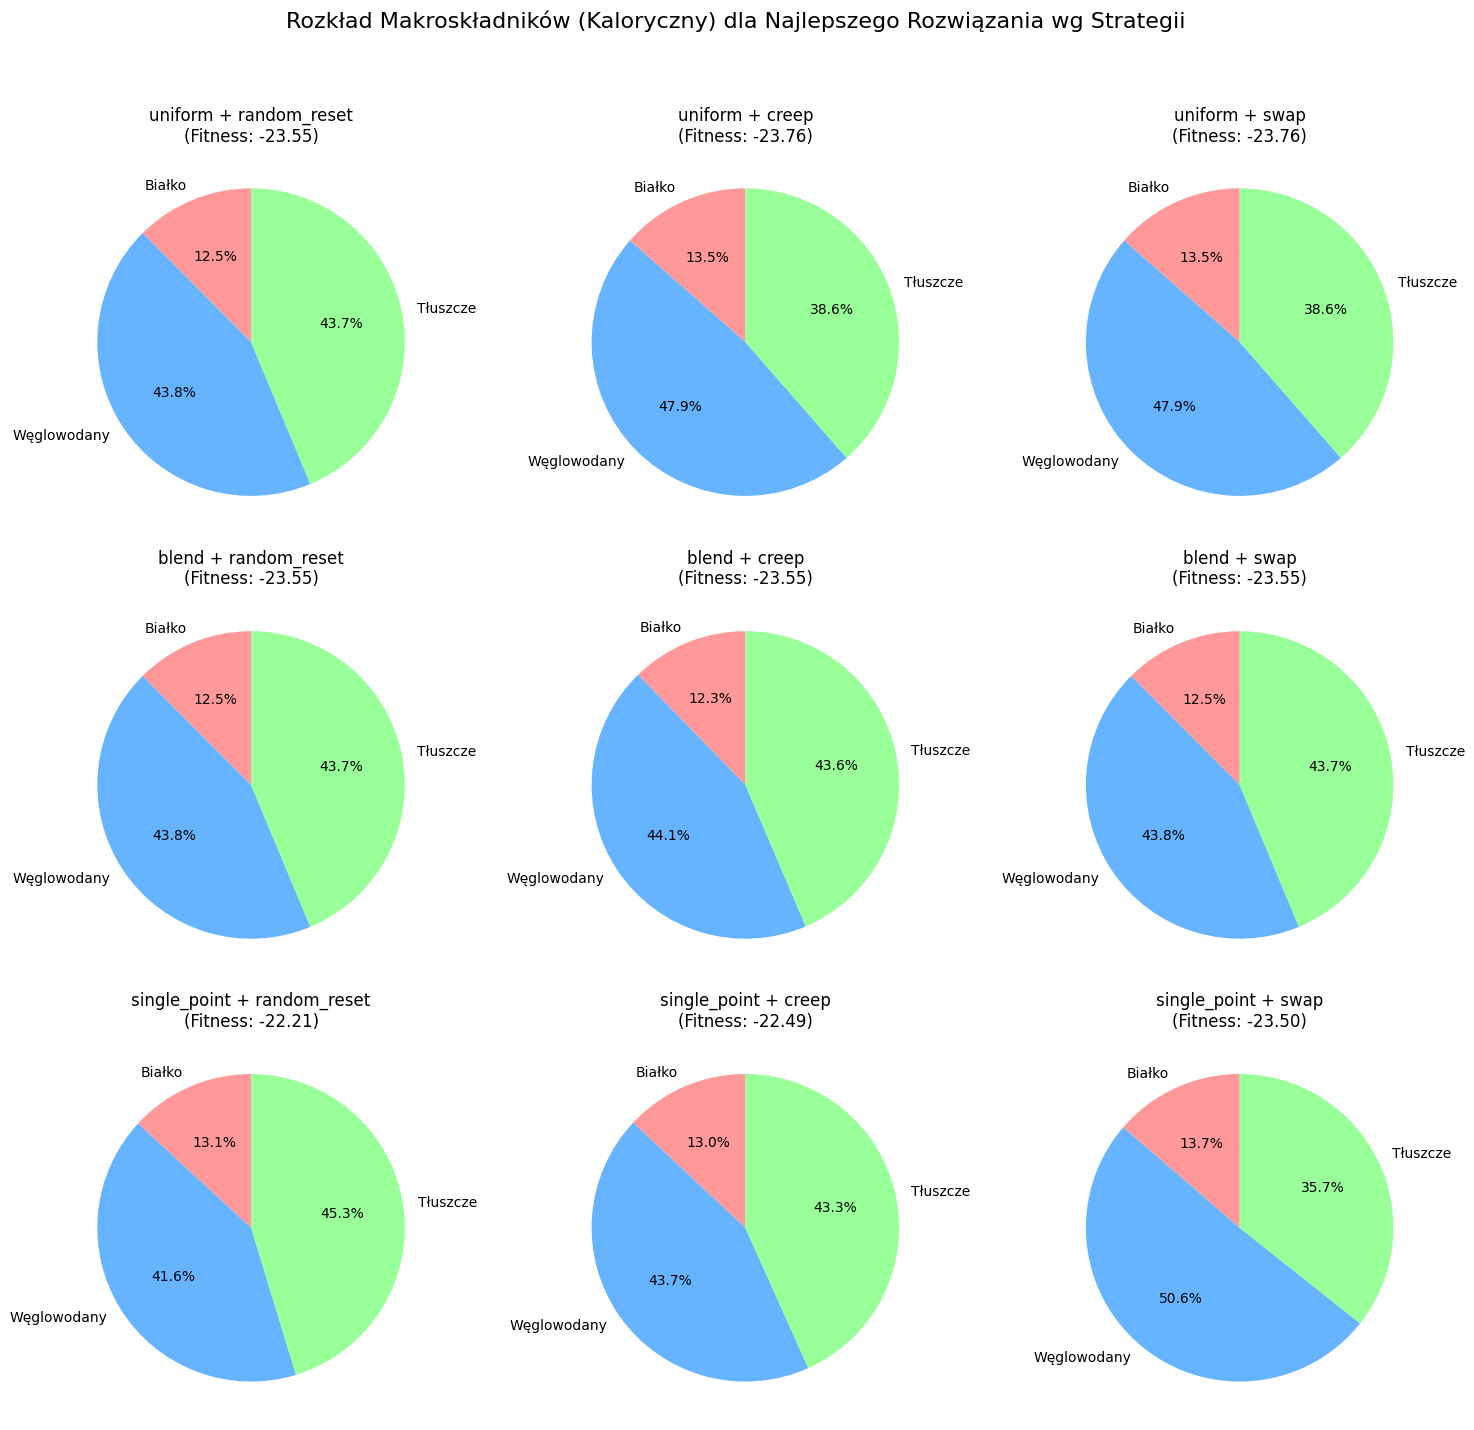

In [29]:
# Utwórz siatkę 3x3 dla wykresów kołowych
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Rozkład Makroskładników (Kaloryczny) dla Najlepszego Rozwiązania wg Strategii', fontsize=16)

# Spłaszcz osie dla łatwej iteracji
axes_flat = axes.flatten()

for i, (name, individual) in enumerate(best_solutions_per_combo.items()):
    ax = axes_flat[i]
    
    # Oblicz statystyki dla tego osobnika
    stats = calculate_nutrition(individual)
    
    # Standardowa konwersja kaloryczna: Białko=4kcal/g, Węglowodany=4kcal/g, Tłuszcz=9kcal/g
    cal_from_prot = stats['protein'] * 4
    cal_from_carb = stats['carbs'] * 4
    cal_from_fat = stats['fat'] * 9
    
    # Dane do wykresu kołowego
    labels = ['Białko', 'Węglowodany', 'Tłuszcze']
    sizes = [cal_from_prot, cal_from_carb, cal_from_fat]
    colors = ['#ff9999','#66b3ff','#99ff99']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(f"{name}\n(Fitness: {calculate_fitness(individual, CONFIG):.2f})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()